<a href="https://colab.research.google.com/github/SNOOthiking/SHOPPING/blob/snoo/W2V_Kkma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dacon 쇼핑몰 리뷰 평점 분류 경진대회 - Word2Vec 2. 분류를 적용해보자
****
- nltk는 한국어 적용이 잘 안된다. 그래서 Kkma를 사용해서 한국어 처리를 해보려고 한다. 
 


## 모듈 임포트

In [22]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import re 
import pandas as pd
import numpy as np 
from gensim.models import Word2Vec
from gensim.models import KeyedVectors 
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt
from collections import Counter
from sklearn.linear_model import LogisticRegression
from konlpy.tag import Kkma # 서울대에서 만든 한국어 자연어 모델 
import seaborn as sns

In [24]:
kma =Kkma(max_heap_size=1024*6)  # 힙사이즈 강제할당

In [25]:
from google.colab import drive
from os.path import join

ROOT = "/content/drive"
print(ROOT)
drive.mount(ROOT)

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
train = pd.read_csv('/content/drive/MyDrive/dacon_shopping/shopping_git/dataset/train.csv')
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(train, test_size=0.25, stratify = train.target,random_state=42) 
# 전처리 과정에서 데이터가 뒤섞이지 않도록 인덱스를 초기화
train_data = train_data.reset_index().drop('index', axis=1)
val_data = val_data.reset_index().drop('index', axis=1)
# training 데이터에서 변수 추출
train_X = train_data.reviews
train_y = train_data.target 
# validation 데이터에서 변수 추출
val_X = val_data.reviews 
val_y = val_data.target 


## 데이터 확인

(18750,)
(6250,)


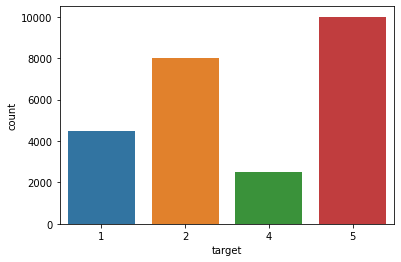

In [27]:
print(train_X.shape)
print(val_X.shape)
sns.countplot(data=train,x='target')

## 문장의 공백 제거 
- Kkma 의 오류로 인해 15자 이상은 활용할 수 없음 
- 따라서 최대한 활용할 수 있도록 공백 제거 

In [28]:
train_X = train_X.str.replace(' ','')
val_X = val_X.str.replace(' ','')

In [29]:
train_X

0                                          마음에듭니다.자주이용할께요~
1                           어머니다용도가방으로사드렸습니다.현재까진매우만족입니다!!
2                                           빨아놔써쇼색상이너무이쁘네요
3                                               향이좋아요맘에들어요
4                                                편해서좋으네요^^
                               ...                        
18745    재구매두번째구매인데맛도없고안달아요전혀...배송은일주일넘게똑같이걸렸는데처음시켰던건알도...
18746                                    너무낮아서밑에곁대어서쓰고있습니다
18747        늘쓰던거에요.근데리뉴얼이된건지..좀두툼해진거같더라구요.아닌가..아무튼더마음에드네요
18748                          향이너무독하고배송도느렸어요ㅠㅠ가격은저렴한것같습니다
18749    생각했던거보단별로였던거같아요.사이즈는제가안재고사서...생각보다많이작다는느낌을받았고두...
Name: reviews, Length: 18750, dtype: object

## 정규표현식 특수문자 제거

In [30]:
def apply_regular_expression(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')
    result = hangul.sub('',text)
    return result

In [31]:
train_X = train_X.map(apply_regular_expression)
val_X = val_X.map(apply_regular_expression)

## 한국어 특성상 뒤에 느낌을 표현하는 경우가 많음
- 뒤에서 15글자, 15글자로 한정한 이유 = Kkma 는 JVM 기반 자바모듈인데 자바의 heap에 계속 쌓이면서 문장의 길이가 길면 out of memory error 를 발생시킨다. 나는 heap사이즈를 강제로 키워도 보았지만 15글자 이상에서는 메모리 문제가 발생했다. 그래서 모든 문장을 15글자로 제한을 두었기 때문에 필요한 단어만 찾을 필요가 있었다. 앞에서 중간에서 가장 마지막에서 등등.. 한국어 문장 특성상 대부분이 두괄식 표현보다는 끝에 자기의 감정을 적는 경우가 많았다. 그래서 뒤에서 15글자로 제한을 두었다

In [32]:
train_short = []
for i in range(len(train_X)):
    train_short.append(train_X[i][-15:])
train_short = pd.Series(train_short)

val_short = []
for i in range(len(val_X)):
    val_short.append(val_X[i][-15:])
val_short = pd.Series(val_short)

## 형태소를 확인해서 단어화 하는 작업. 

In [33]:
def text_cleaning(text):
    b = ''
    nouns = kma.pos(text) 
    for i in range(len(nouns)):
        if 'NNG' in nouns[i]:
            b += nouns[i][0]+','
        elif 'XR' in nouns[i]:
            b += nouns[i][0]+','
        elif 'VA' in nouns[i]:
            if nouns[i-1][0] == '안':
                b += '안' + nouns[i][0]+'다'+','
            else:
                b += nouns[i][0]+'다'+','
        elif 'VV' in nouns[i]:
                b += nouns[i][0]+'다'+','
        else:
            pass
    return b

In [34]:
train_clean = train_short.map(text_cleaning)
val_clean = val_short.map(text_cleaning)

In [35]:
train_list = list(map(lambda x:x.split(',')[:-1],train_clean))
val_list = list(map(lambda x : x.split(',')[:-1],val_clean))

## 한글자제거 (한글자는 불필요한 단어) 

In [36]:
train_rmone = [] 
for x in train_list:
    abcd = []
    for i in x:
        if len(i) >1 :
            abcd.append(i)
    train_rmone.append(abcd)
val_rmone = []
for x in val_list:
    abcd = []
    for i in x:
        if len(i) > 1 :
            abcd.append(i)
    val_rmone.append(abcd)
    

## stopword (불용어 제거)

In [37]:
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()

In [38]:
train_rmstop = []
for x in train_rmone:
    abcd = []
    for i in x:
        if i not in stopwords:
            abcd.append(i)
    train_rmstop.append(abcd)
val_rmstop = []
for x in val_rmone:
    abcd = []
    for i in x:
        if i not in stopwords:
            abcd.append(i)
    val_rmstop.append(abcd)

## word 2 vec 학습 


In [40]:
model = Word2Vec(sentences = train_rmstop, # 학습
                 size=100,      # 임베딩된 벡터 차원 
                 window=10,             # 컨텍스트 윈도우 크기
                 min_count=1,          # 최소 빈도수 제한 1번 밑으로는 학습 X
                 workers=40,           # 학습 프로세스 수 
                 sg=1)                 # 0= CBOW, 1= Skip-Gram
                                       # skipgram = 중심단어로 주변단어 예측 

In [41]:
model.wv.most_similar('좋다')

[('상품', 0.9988223314285278),
 ('만족', 0.9986308217048645),
 ('제품', 0.99790358543396),
 ('감사', 0.9978794455528259),
 ('포장', 0.9974327087402344),
 ('품질', 0.997244119644165),
 ('깔끔', 0.9971938133239746),
 ('상태', 0.9971717596054077),
 ('괜찮다', 0.9967938661575317),
 ('저렴', 0.9966132044792175)]

In [42]:
model.wv.most_similar('안좋다')

[('필요', 0.999640166759491),
 ('팔다', 0.9996260404586792),
 ('짜다', 0.999615490436554),
 ('불량', 0.9996150135993958),
 ('나쁘다', 0.9996144771575928),
 ('처음', 0.9996100664138794),
 ('들어가다', 0.9996071457862854),
 ('마감', 0.9996036887168884),
 ('묻다', 0.9996005892753601),
 ('터지다', 0.9995871782302856)]

In [43]:
def get_features(words, model, num_features):
    feature_vector = np.zeros((num_features),dtype=np.float32)

    num_words = 0
    index2word_set = set(model.wv.index2entity)

    for w in words:
        if w in index2word_set:
            num_words = 1
            feature_vector = np.add(feature_vector, model.wv[w])
        elif w not in index2word_set:
            num_words = 1
            feature_vector = np.add(feature_vector,model.wv['보통'])
        feature_vector = np.divide(feature_vector, num_words)
    return feature_vector
def get_dataset(reviews, model, num_features):
    dataset = list()

    for s in reviews:
        dataset.append(get_features(s, model, num_features))

    reviewFeatureVecs = np.stack(dataset)
    
    return reviewFeatureVecs



## 문장마다 벡터값 얻기 

In [44]:
train_vec = get_dataset(train_rmstop,model,100)
val_vec = get_dataset(val_rmstop,model,100)

## Logistic Regression 모델로 평가

In [45]:
lr_clf =LogisticRegression(max_iter=10000,random_state=42)

In [46]:
lr_clf.fit(train_vec,train_y)

LogisticRegression(max_iter=10000, random_state=42)

In [47]:
pred = lr_clf.predict(val_vec)

In [48]:
(pred == val_y).mean()

0.54016

## 랜덤포레스트와 그라디언트부스팅기법 

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [50]:
rf_clf = RandomForestClassifier(n_estimators=107,random_state=0,
                                n_jobs=-1,criterion='gini',
                                max_depth=14,min_samples_leaf=11
                               )
gb_clf = GradientBoostingClassifier(n_estimators=100)

In [51]:
rf_clf.fit(train_vec,train_y)

RandomForestClassifier(max_depth=14, min_samples_leaf=11, n_estimators=107,
                       n_jobs=-1, random_state=0)

In [52]:
rf_pred = rf_clf.predict(val_vec)

In [53]:
(rf_pred==val_y).mean()

0.53056

In [54]:
gb_clf.fit(train_vec,train_y)

GradientBoostingClassifier()

In [55]:
gb_pred = gb_clf.predict(val_vec)

In [56]:
(gb_pred==val_y).mean()

0.51552

# 결론
- 생각만큼 좋은 수치가 나오지 않았다. word2vec의 학습에서 최대한 활용할 수 있을 언어만 뽑아왔다고 생각했다. 문장의 처음과 끝을 다 해석했다면 다르겠지만 자바 메모리 오류로 그렇게 하지 못한건 아쉬움이다. 
- 최대한 성능을 업그레이드해보려고 노력했다. 여기서는 이정도로 적어 놓겠지만 사실 더 많은 시도를 해보았다.adaboost기법도 파이프라인을 적용해 원핫인코딩으로도 하지만 모두 성능이 좋지 않았다. 그 뜻은 word2vec 이전에 단어 뽑는 부분이 문제가 있다고 생각이 든다. 
---
1. 자연어 처리에서는 학습된 모델을 쓰는 것이 가장 좋다고 한다. 
2. skt에서 만든 KoGPT2 를 이용할 예정이다.
3. 카카오에서 만든 KoGPT는 16기가 RAM으로 코랩에서 사용이 불가능하다. 

